In [ ]:
# Define where you are running the code: colab or local
RunInColab          = True     # (False: no  | True: yes)

# If running in colab:
if RunInColab:
    # Mount your google drive in google colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Find location
    #!pwd
    #!ls
    #!ls "/content/drive/My Drive/Colab Notebooks/MachineLearningWithPython/"

    # Define path del proyecto
    Ruta            = "/content/drive/My Drive/Colab Notebooks/"

else:
    # Define path del proyecto
    Ruta            = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the packages that we will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset url
url = Ruta + "data_filtered.csv"

# Load the dataset
dataset = pd.read_csv(url)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import time
start = time.time()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
plt.style.use('seaborn')

np.set_printoptions(precision=4)

## Read data

In [ ]:
data = dataset
data['date'] = pd.to_datetime(data['date'])

In [ ]:
len(data)

5583

In [ ]:
data.head()

,year,date,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,...,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
0,2011,2011-03-27,\N,\N,\N,\N,\N,\N,\N,\N,...,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nick Heidfeld,12374,0,0,0,1
1,2010,2010-03-28,\N,\N,\N,\N,\N,\N,\N,\N,...,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Robert Kubica,9242,0,0,0,0
2,2017,2017-03-26,\N,\N,\N,\N,\N,\N,\N,\N,...,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,10812,0,0,0,1
3,2018,2018-03-25,\N,\N,\N,\N,\N,\N,\N,\N,...,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11176,0,0,0,0
4,2019,2019-03-17,\N,\N,\N,\N,\N,\N,\N,\N,...,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11533,0,0,0,1


In [ ]:
new_test = data["driver_dnf"]
new_test.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
5578    0
5579    0
5580    0
5581    0
5582    0
Name: driver_dnf, Length: 5583, dtype: int64>

In [ ]:
data['year'].unique()

array([2011, 2010, 2017, 2018, 2019, 2016, 2014, 2015, 2012, 2013, 2022,
       2023, 2020, 2021])

Si utilizan datos del 2023, por que al entrenar los modelos no usan el archivo data_filtered_2021.csv, usan el data_filtered.csv

## Do data transformations

El calculo de driver_confidence y constructor reliability es incorrecto, ya que el calculo de estas variables es de todo el historial de datos que hay. Y esto nos da dos sesgos, uno el modelo tiene conocimiento del presente pasado y futuro, y el segundo es que tan bueno es una escuderia o un corredor puede cambiar cada 2 o 3 años, aunque hay algunos que duran mas.
Pero en si seria bueno limitarlo a 2 años antes de la carrera estos datos.

In [ ]:
def get_reliability_driver_const(data, column):
  # Solo vamos a calcular 2 año atras la informacion de cuantas carrreras entro y cuantas veces tuvo dnf, en vez de calcular de todo el historial de las carreras
  data_temp_dnf = data.copy()
  data_temp_dnf['index_column'] = data_temp_dnf.index
  data_temp_dnf.set_index('date', inplace=True)
  data_temp_dnf.sort_index(inplace=True)


  window_size = '730D' # 2 years

  # data_temp_dnf['rolling_sum_1'] = data_temp_dnf.groupby('driver')['driver_dnf'].apply(lambda x: x.shift().rolling(window_size).sum())
  # data_temp_dnf['rolling_sum_2'] = data_temp_dnf.groupby('driver')['driver_dnf'].apply(lambda x: x.shift().rolling(window_size).count())

  all_columns = data[column].unique()

  for column_row in all_columns:
      data_temp_dnf.loc[data_temp_dnf[column] == column_row, 'total_dnf'] = data_temp_dnf[data_temp_dnf[column] == column_row].shift().rolling(window_size)[f'{column}_dnf'].sum()
      data_temp_dnf.loc[data_temp_dnf[column] == column_row, 'total_races'] = data_temp_dnf[data_temp_dnf[column] == column_row].shift().rolling(window_size)[f'{column}_dnf'].count()


  data_temp_dnf['dnf_ratio'] = 1 - (data_temp_dnf['total_dnf'] / data_temp_dnf['total_races'])

  data_temp_dnf.reset_index(inplace=True)
  data_temp_dnf.set_index('index_column', inplace=True)
  data_temp_dnf.sort_index(inplace=True)
  data_temp_dnf.reset_index(inplace=True)

  return data_temp_dnf['dnf_ratio']

In [ ]:
# dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
# driver_race_entered = data.groupby('driver').count()['driver_dnf']
# driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
# driver_confidence = 1-driver_dnf_ratio
# driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [ ]:
# dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
# constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
# constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
# constructor_reliability = 1-constructor_dnf_ratio
# constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [ ]:
# data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
# data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])

data['driver_confidence'] = get_reliability_driver_const(data, 'driver')
data['driver_confidence'] = data['driver_confidence'].fillna(0)
data['constructor_reliability'] = get_reliability_driver_const(data, 'constructor')
data['constructor_reliability'] = data['constructor_reliability'].fillna(0)


#removing retired drivers and constructors
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Mick Schumacher', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Yuki Tsunoda',
                  'Max Verstappen', 'Pierre Gasly', 'Fernando Alonso',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Nikita Mazepin','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

La variable de dnf no se usaria para entrenar el modelo directamente, porque esta ya nos da la inforacion de si acabo la carrera o no

In [ ]:
import os
if not os.path.exists('./models'):
    os.mkdir('./models')

In [ ]:
data.dtypes

year                                int64
date                       datetime64[ns]
fp1_date                           object
fp1_time                           object
fp2_date                           object
fp2_time                           object
fp3_date                           object
fp3_time                           object
quali_date                         object
quali_time                         object
sprint_date                        object
sprint_time                        object
quali_pos                           int64
statusId                            int64
position                            int64
dob                                object
driver_nationality                 object
constructor                        object
constructor_nationality            object
GP_name                            object
country                            object
driver                             object
age_at_gp_in_days                   int64
driver_home                       

## Study the positions (y) and qualification position variables

In [ ]:
def position_index(x):
    if x < 4:
        return 0 # 1
    if x > 10:
        return 2 # 3
    else:
        return 1 # 2

In [ ]:
# pearson’, ‘kendall’, ‘spearman
def showCorrelation(data, nCols):
    methods=["pearson", "kendall", "spearman"]

    fig, axes = plt.subplots(nrows=len(methods), ncols=nCols, figsize=(5 * len(methods), 10))

    for i, method in enumerate(methods):
        ax = axes[i]
        corr = data.corr(method=method)
        sns.heatmap(corr, annot=True, ax=ax)
        ax.set_title(f'{method.capitalize()} Correlation')

    plt.tight_layout()
    plt.show()

In [ ]:
def factorizeColumns(data, colName, factColName):
    data[factColName] = pd.factorize(data[colName])[0]
    data[factColName].head

In [ ]:
def graph_diff_pos_quali_pos(all_gps_year, all_year_data):
  ncols = 2
  nrows = (len(all_gps_year) + 1) // ncols

  fig, axes = plt.subplots(nrows, ncols, figsize=(20, 70))

  for index, race in enumerate(all_gps_year.iterrows()):
      race = race[1]
      ax = axes[index // ncols, index % ncols]

      race_name = race['GP_name']
      race_date = race['date']
      race_data = all_year_data[all_year_data['GP_name'] == race_name]

      unique_race = race_data[race_data['date'] == race_date]
      
      ax.scatter(unique_race["driver"], unique_race["quali_pos"], color='k')
      ax.scatter(unique_race["driver"], unique_race["position"], color='g')

      ax.set_xticklabels(unique_race["driver"], rotation=90)
      ax.set_title(f"Grand prix {race_name}, {race_date}")

  plt.tight_layout()
  plt.show()

In [ ]:
data["active_driver"].head()

0    0
1    0
2    0
3    0
4    0
Name: active_driver, dtype: int64

In [ ]:
temp = data["driver"].unique()
len(temp)

76

In [ ]:
year2020 = data[data["year"] == 2020]
races = year2020["GP_name"].unique()

In [ ]:
all_gps_2020 = year2020[['GP_name', 'date']].drop_duplicates()

In [ ]:
race_data_temp = year2020[year2020['GP_name'] == races[0]]

race_data_temp[['position', 'quali_pos', 'driver', 'constructor', 'date']]

,position,quali_pos,driver,constructor,date
655,6,6,Daniel Ricciardo,Alpine F1,2020-11-29
656,7,7,Daniel Ricciardo,Alpine F1,2020-12-06
661,7,7,Esteban Ocon,Alpine F1,2020-11-29
662,11,11,Esteban Ocon,Alpine F1,2020-12-06
683,14,14,George Russell,Williams,2020-11-29
685,20,20,Nicholas Latifi,Williams,2020-11-29
686,17,16,Nicholas Latifi,Williams,2020-12-06
689,18,17,Jack Aitken,Williams,2020-12-06
706,15,15,Carlos Sainz,McLaren,2020-11-29
707,8,8,Carlos Sainz,McLaren,2020-12-06


In [ ]:
print(all_gps_2020)

                                   GP_name       date
655          Bahrain International Circuit 2020-11-29
656          Bahrain International Circuit 2020-12-06
949         Circuit de Barcelona-Catalunya 2020-08-16
1479                         Istanbul Park 2020-11-15
1570                   Silverstone Circuit 2020-08-02
1571                   Silverstone Circuit 2020-08-09
1861                           Nürburgring 2020-10-11
1933                           Hungaroring 2020-07-19
2282          Circuit de Spa-Francorchamps 2020-08-30
2556          Autodromo Nazionale di Monza 2020-09-06
3560                    Yas Marina Circuit 2020-12-13
4193         Autodromo Enzo e Dino Ferrari 2020-11-01
4257                         Red Bull Ring 2020-07-05
4258                         Red Bull Ring 2020-07-12
4574                        Sochi Autodrom 2020-09-27
5363  Autodromo Internazionale del Mugello 2020-09-13
5383    Autódromo Internacional do Algarve 2020-10-25


### Graph the difference in qualification position and position in the year 2020

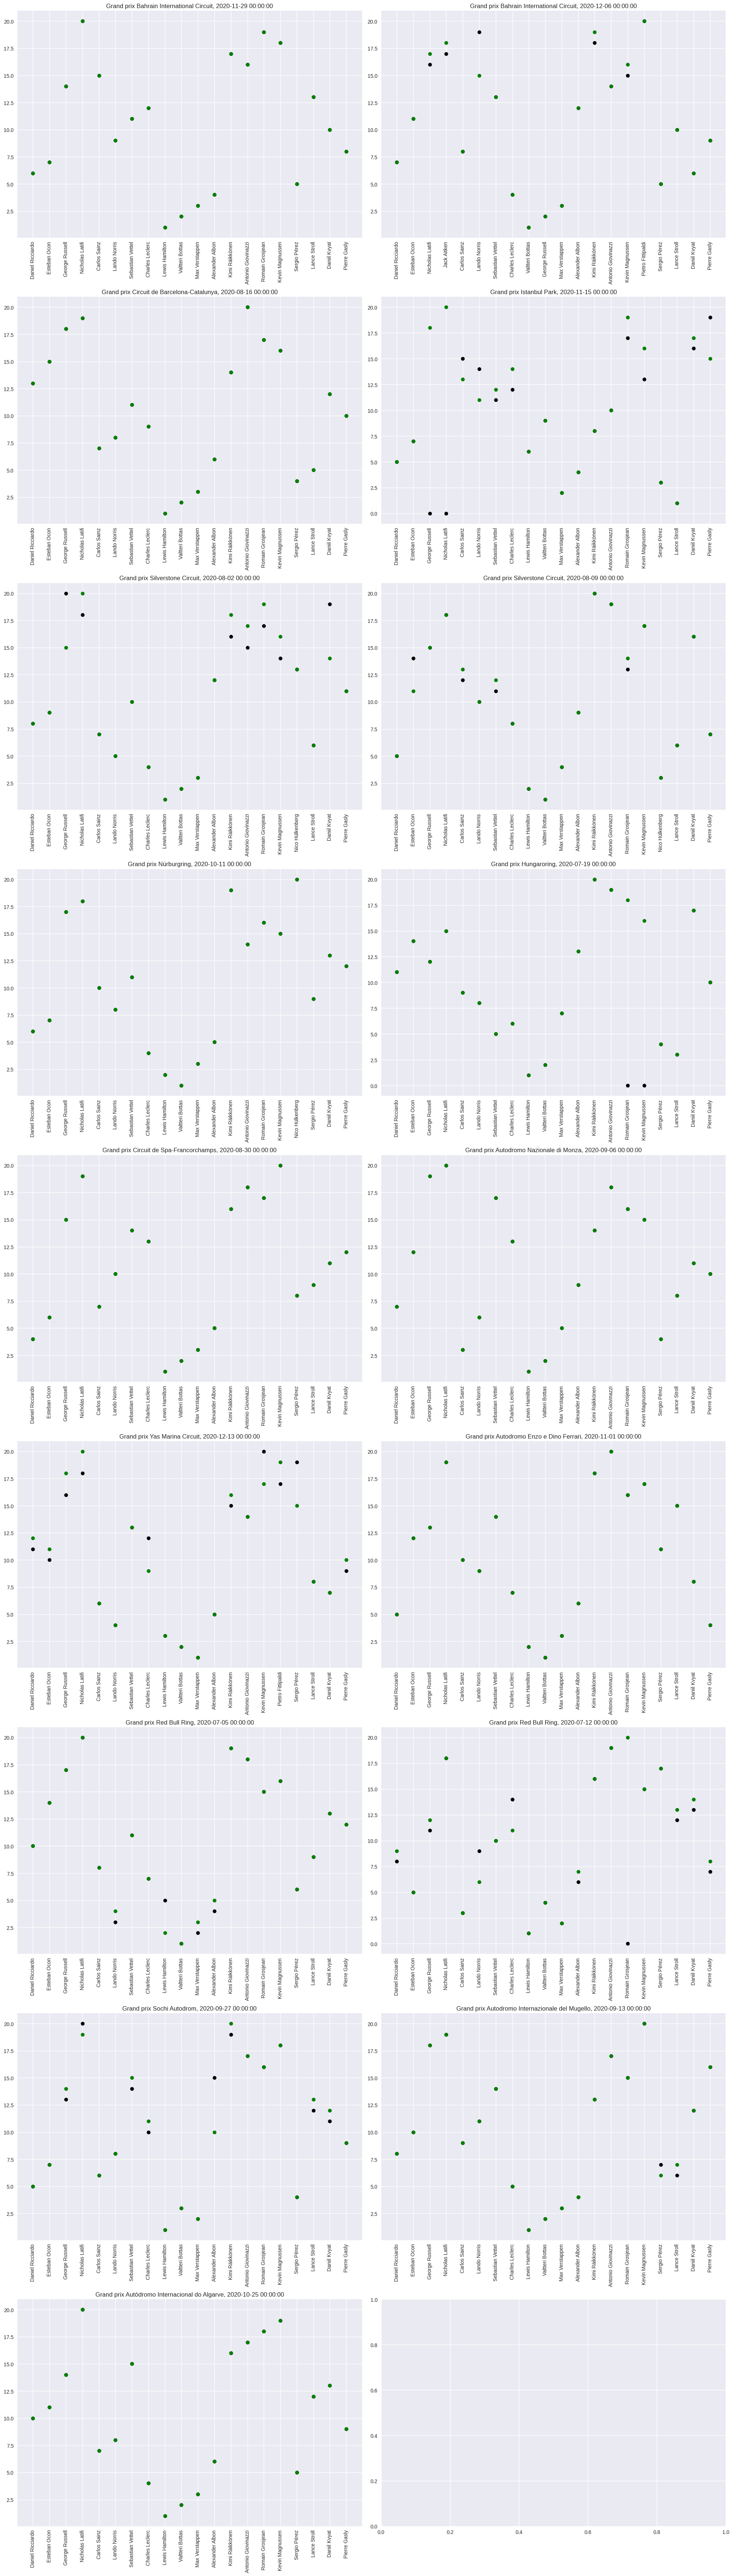

In [ ]:
graph_diff_pos_quali_pos(all_gps_2020, year2020)

In [ ]:
year2020_in_3_classes = year2020.copy()
year2020_in_3_classes["position"] = year2020_in_3_classes["position"].apply(lambda x: position_index(x)) 
year2020_in_3_classes["quali_pos"] = year2020_in_3_classes["quali_pos"].apply(lambda x: position_index(x)) 

In [ ]:
all_gps_2020_in_3_classes = year2020_in_3_classes[['GP_name', 'date']].drop_duplicates()

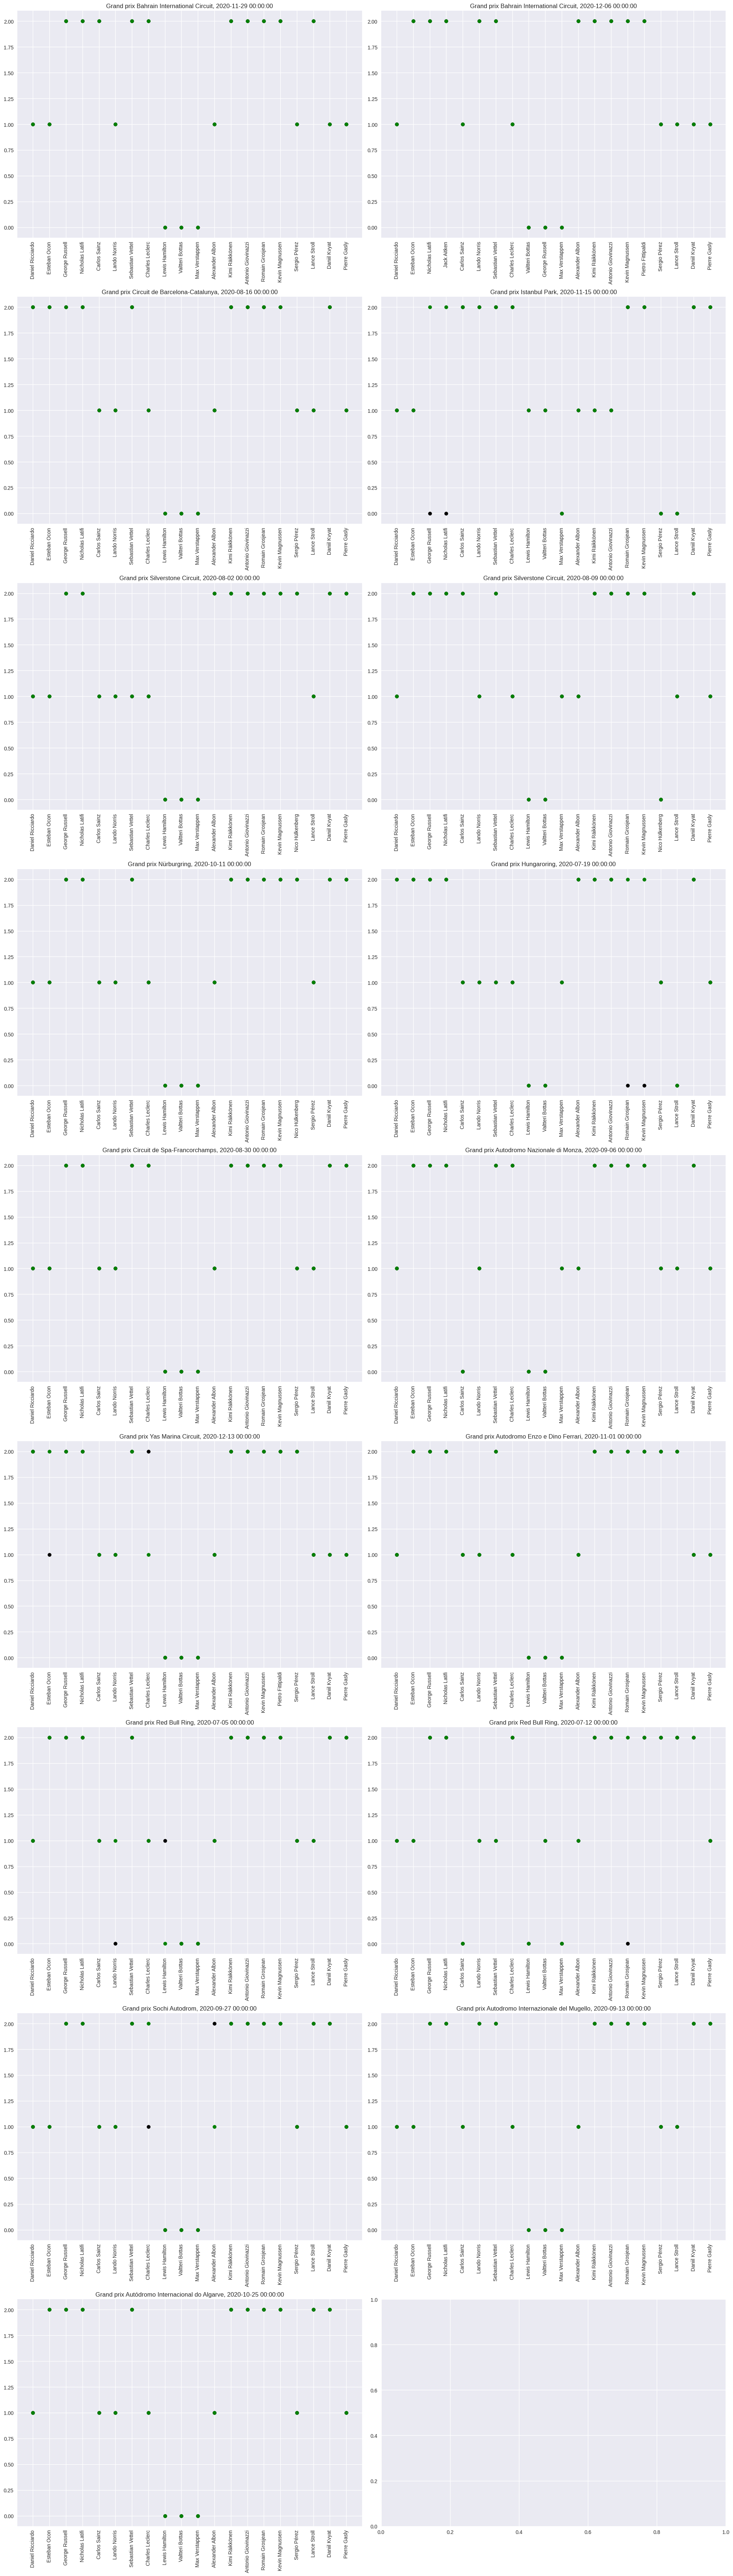

In [ ]:
graph_diff_pos_quali_pos(all_gps_2020_in_3_classes, year2020_in_3_classes)

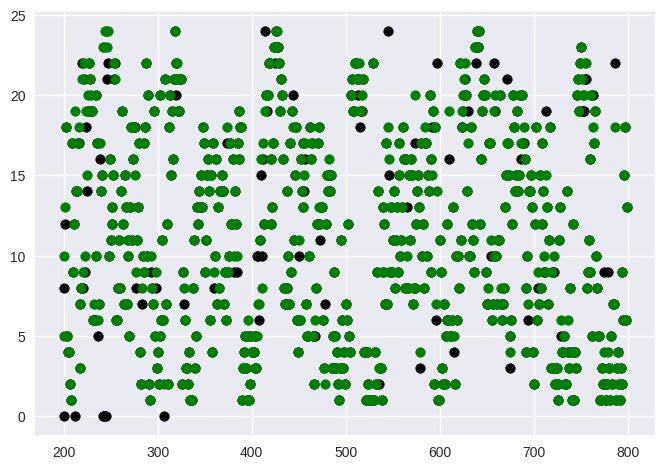

In [ ]:
fig, ax = plt.subplots()

#ax.plot(list(data.index.values.tolist())[:50], data["quali_pos"][:50], 'o', label='Graph 1')
#ax.plot(list(data.index.values.tolist())[:50], data["position"][:50], 'x', label='Graph 2') 
#ax.set_xlabel('ID')
#ax.set_ylabel('Position')
#ax.set_title('Plot of X vs Y')
#ax.grid(True)

#ax.legend()
#plt.show()

plt.scatter(list(data.index.values.tolist())[200:800], data["quali_pos"][200:800], color='k')
plt.scatter(list(data.index.values.tolist())[200:800], data["position"][200:800],color='g')
plt.show()

### Calculate the mean difference and standard deviation of changes in qualification position and position

In [ ]:
diff_quali_pos = data[["position", "quali_pos"]]
diff_quali_pos['position_3_classes'] = diff_quali_pos['position'].apply(lambda x: position_index(x))
diff_quali_pos['quali_pos_3_classes'] = diff_quali_pos['quali_pos'].apply(lambda x: position_index(x))

diff_quali_pos['diff'] = diff_quali_pos['quali_pos'] - diff_quali_pos['position']
diff_quali_pos['diff_3_classes'] = diff_quali_pos['quali_pos_3_classes'] - diff_quali_pos['position_3_classes']


In [ ]:
print(f"Unique qualification position: {diff_quali_pos['quali_pos'].unique()}")
print(f"Unqiue positions: {diff_quali_pos['position'].unique()}")

Unique qualification position: [18  9 11  7  6 12 14 13 19  8 17 20  3 15 16  0  4  2 10  1  5 23 21 24
 22]
Unqiue positions: [18  9 12  8 11  6 15 14 20 17  3  7 16 10 19  4  2 13  1  5 21 22 23 24]


Qualification position 0?

La informacion del dataset parece estar mal, la carrera del 2015 es un ejemplo en donde Valtteri Bottas no llego a competir en la carrera, por esto el quali_pos 0, pero la position en la carrera dice que es 6 cuando deberia de ser DNS (Did not start), y las posicion en esa carrera estan mal tambien ya que Vettel quedo en 3 lugar y esta dice en cuarto lugar

In [ ]:
data[data['quali_pos'] == 0][["date", "GP_name", "position", "quali_pos", "driver"]]

,date,GP_name,position,quali_pos,driver
26,2015-03-15,Albert Park Grand Prix Circuit,6,0,Valtteri Bottas
196,2023-04-02,Albert Park Grand Prix Circuit,20,0,Sergio Pérez
200,2017-03-26,Albert Park Grand Prix Circuit,10,0,Daniel Ricciardo
212,2023-04-02,Albert Park Grand Prix Circuit,19,0,Valtteri Bottas
242,2011-03-27,Albert Park Grand Prix Circuit,23,0,Vitantonio Liuzzi
243,2012-03-18,Albert Park Grand Prix Circuit,23,0,Pedro de la Rosa
244,2011-03-27,Albert Park Grand Prix Circuit,24,0,Narain Karthikeyan
245,2012-03-18,Albert Park Grand Prix Circuit,24,0,Narain Karthikeyan
307,2017-10-01,Sepang International Circuit,2,0,Kimi Räikkönen
854,2021-03-28,Bahrain International Circuit,11,0,Sergio Pérez


In [ ]:
data[data['date'] == '2015-03-15'][['quali_pos', 'position', 'GP_name', 'date', 'driver']]

,quali_pos,position,GP_name,date,driver
16,3,3,Albert Park Grand Prix Circuit,2015-03-15,Felipe Massa
26,0,6,Albert Park Grand Prix Circuit,2015-03-15,Valtteri Bottas
41,16,17,Albert Park Grand Prix Circuit,2015-03-15,Jenson Button
52,17,18,Albert Park Grand Prix Circuit,2015-03-15,Kevin Magnussen
65,4,4,Albert Park Grand Prix Circuit,2015-03-15,Sebastian Vettel
71,5,5,Albert Park Grand Prix Circuit,2015-03-15,Kimi Räikkönen
111,2,2,Albert Park Grand Prix Circuit,2015-03-15,Nico Rosberg
115,1,1,Albert Park Grand Prix Circuit,2015-03-15,Lewis Hamilton
142,7,8,Albert Park Grand Prix Circuit,2015-03-15,Carlos Sainz
145,11,12,Albert Park Grand Prix Circuit,2015-03-15,Max Verstappen


In [ ]:
len(data[data['quali_pos'] == 0][["date", "GP_name", "position", "quali_pos", "driver"]])

57

#### Analysis of difference in qualification position and position

In [ ]:
print(f"Mean: {diff_quali_pos['diff'].mean()}")
print(f"Standard deviation: {diff_quali_pos['diff'].std()}")

Mean: -0.18251835930503313
Standard deviation: 2.3588423409618082


In [ ]:
print(f"Value counts:\n {diff_quali_pos['diff'].value_counts()}")
print(f"Value counts in percentage:\n {diff_quali_pos['diff'].value_counts(normalize=True)}")

Value counts:
  0     3831
-1      985
-2      194
 5       89
-3       73
 3       68
 4       58
 2       56
 1       43
-4       28
 10      21
-5       15
-6       12
 6       10
-19       9
-20       9
 7        8
 8        8
 9        8
-10       6
 11       6
-7        5
-14       5
-18       4
-8        3
-16       3
-12       3
 13       2
 18       2
-17       2
 15       2
-11       2
-24       2
-23       2
-13       2
 16       1
-21       1
-22       1
 23       1
 14       1
 21       1
 17       1
Name: diff, dtype: int64
Value counts in percentage:
  0     0.686190
-1     0.176428
-2     0.034748
 5     0.015941
-3     0.013075
 3     0.012180
 4     0.010389
 2     0.010030
 1     0.007702
-4     0.005015
 10    0.003761
-5     0.002687
-6     0.002149
 6     0.001791
-19    0.001612
-20    0.001612
 7     0.001433
 8     0.001433
 9     0.001433
-10    0.001075
 11    0.001075
-7     0.000896
-14    0.000896
-18    0.000716
-8     0.000537
-16    0.000537
-12    0.00

#### Box plot of difference of all data

In [ ]:
# Calculate quartiles and IQR
q1 = diff_quali_pos['diff'].quantile(0.25)
q3 = diff_quali_pos['diff'].quantile(0.75)
iqr = q3 - q1

# Define the threshold for outliers (e.g., 1.5 times the IQR)
threshold = 1.5

# Find outliers
outliers = diff_quali_pos[(diff_quali_pos['diff'] < q1 - threshold * iqr) | (diff_quali_pos['diff'] > q3 + threshold * iqr)]

# Print the outliers
outliers['diff'].unique()

array([ -1,   5,  -6,   1,   4,   2, -20, -10,   3, -19, -23, -24,  -2,
         6,  -3,   8, -11,  10, -16,  23,  15,  11,  -8, -22, -21, -18,
         7,  -4,  16,  -5, -14,   9,  -7,  13, -12,  14,  18, -17,  21,
        17, -13])

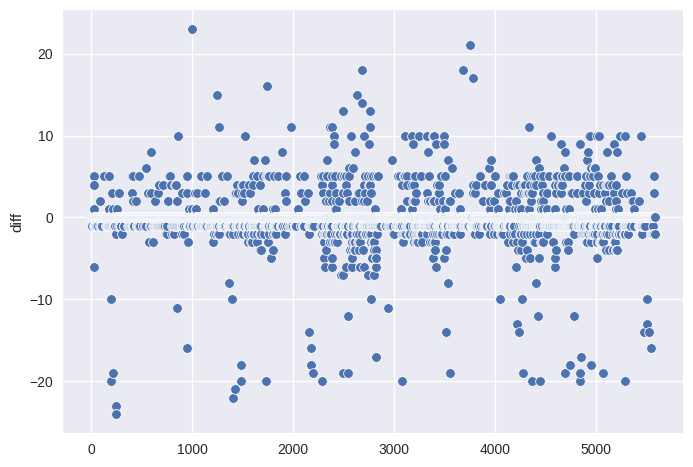

In [ ]:
sns.scatterplot(diff_quali_pos['diff'])
plt.show()

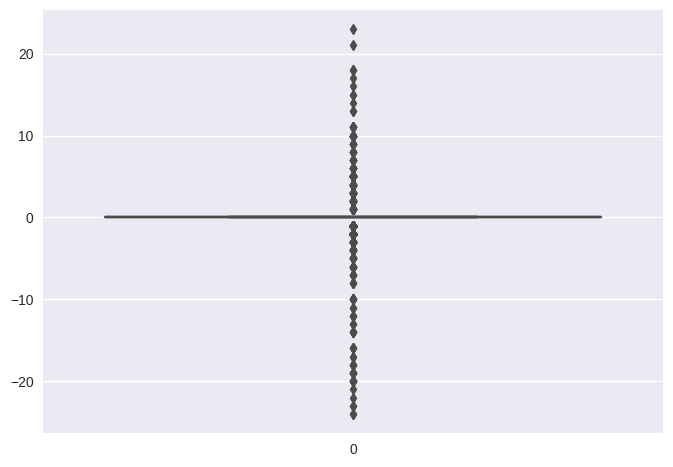

In [ ]:
sns.boxplot(diff_quali_pos['diff'])
plt.show()

#### Box plot difference by qualification position

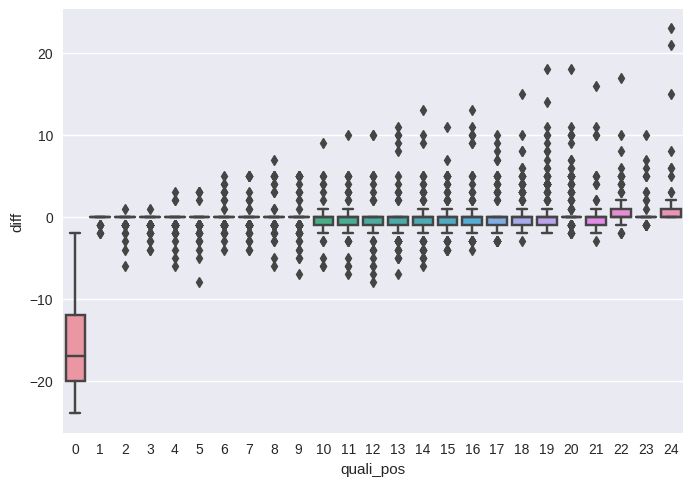

In [ ]:
sns.boxplot(diff_quali_pos, x='quali_pos', y='diff')
plt.show()

#### Analysis of difference of Qualification position and position using only 3 classes

In [ ]:
print(f"Mean of 3 classes: {diff_quali_pos['diff_3_classes'].mean()}")
print(f"Standard deviation of 3 classes: {diff_quali_pos['diff_3_classes'].std()}")

Mean of 3 classes: -0.01934443847393874
Standard deviation of 3 classes: 0.29076025596728977


In [ ]:
print(f"Value counts:\n {diff_quali_pos['diff_3_classes'].value_counts()}")
print(f"Value counts in percentage:\n {diff_quali_pos['diff_3_classes'].value_counts(normalize=True)}")

Value counts:
  0    5283
-1     143
 1      99
-2      45
 2      13
Name: diff_3_classes, dtype: int64
Value counts in percentage:
  0    0.946265
-1    0.025613
 1    0.017732
-2    0.008060
 2    0.002328
Name: diff_3_classes, dtype: float64


The models created are really bad, because a good model would get 95% of predictions correct if it only predicts the same position for the race as the qualification position

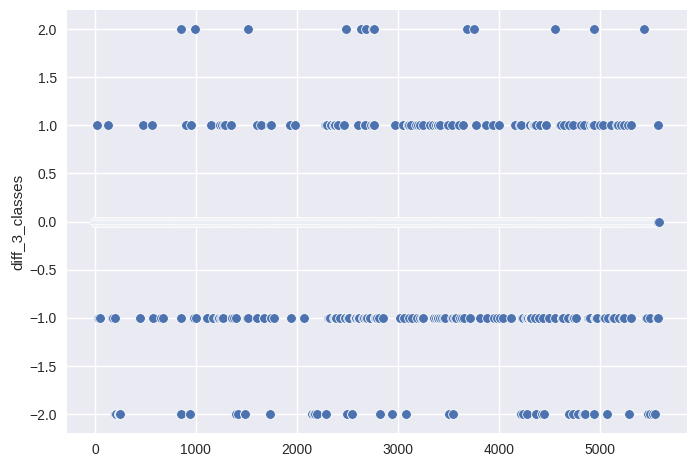

In [ ]:
sns.scatterplot(diff_quali_pos['diff_3_classes'])
plt.show()

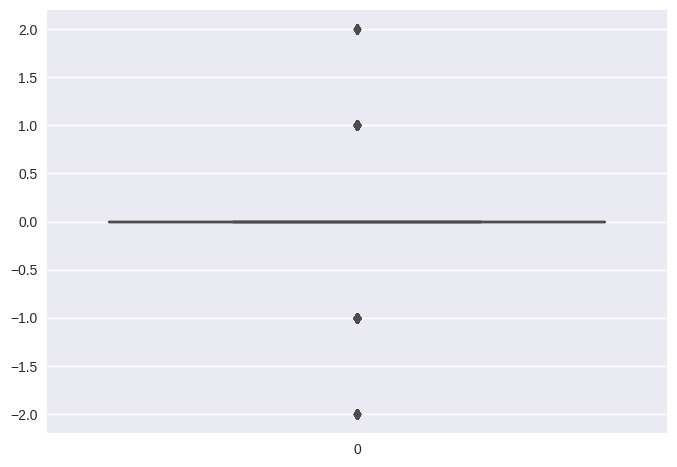

In [ ]:
sns.boxplot(diff_quali_pos['diff_3_classes'])
plt.show()

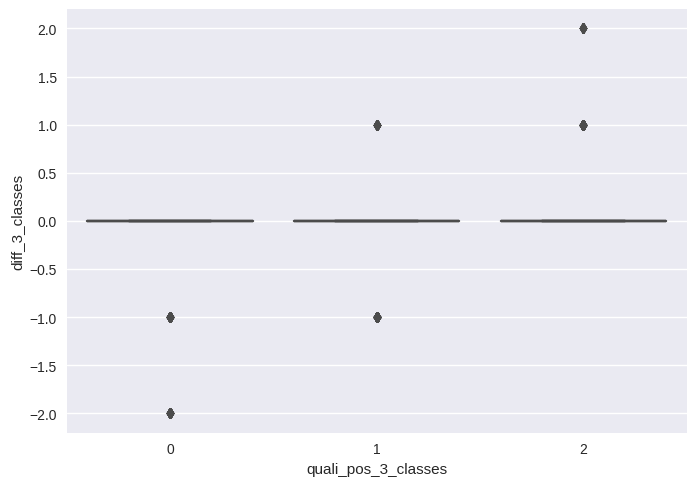

In [ ]:
sns.boxplot(diff_quali_pos, x='quali_pos_3_classes', y='diff_3_classes')
plt.show()

## Show correlation of important variables

- Pearson is linear correlation
- Kendall and spearman are non linear correlations (monotonic relationship)

In [ ]:
data_important = data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver', 'constructor_reliability']]
data_important.dtypes

GP_name                     object
quali_pos                    int64
driver                      object
age_at_gp_in_days            int64
position                     int64
driver_confidence          float64
active_driver                int64
constructor_reliability    float64
dtype: object

In [ ]:
factorizeColumns(data_important, "GP_name", "FactGP_name")
factorizeColumns(data_important, "driver", "FactDriver")
data_important.head()

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,active_driver,constructor_reliability,FactGP_name,FactDriver
0,Albert Park Grand Prix Circuit,18,Nick Heidfeld,12374,18,0.800000,0,0.657895,0,0
1,Albert Park Grand Prix Circuit,9,Robert Kubica,9242,9,1.000000,0,0.500000,0,1
2,Albert Park Grand Prix Circuit,11,Nico Hülkenberg,10812,12,0.850000,0,0.467532,0,2
3,Albert Park Grand Prix Circuit,7,Nico Hülkenberg,11176,8,0.902439,0,0.294872,0,2
4,Albert Park Grand Prix Circuit,11,Nico Hülkenberg,11533,11,0.880952,0,0.414634,0,2


In [ ]:
new_data_important = data_important[['quali_pos','age_at_gp_in_days','position','driver_confidence','constructor_reliability','active_driver',"FactGP_name","FactDriver"]]
new_data_important.head()

,quali_pos,age_at_gp_in_days,position,driver_confidence,constructor_reliability,active_driver,FactGP_name,FactDriver
0,18,12374,18,0.800000,0.657895,0,0,0
1,9,9242,9,1.000000,0.500000,0,0,1
2,11,10812,12,0.850000,0.467532,0,0,2
3,7,11176,8,0.902439,0.294872,0,0,2
4,11,11533,11,0.880952,0.414634,0,0,2


La correlacion inversa de driver_confidence y constructor reliability nos dice que entre mejor confidence y reliability, mejor posicion tendremos en la carrera

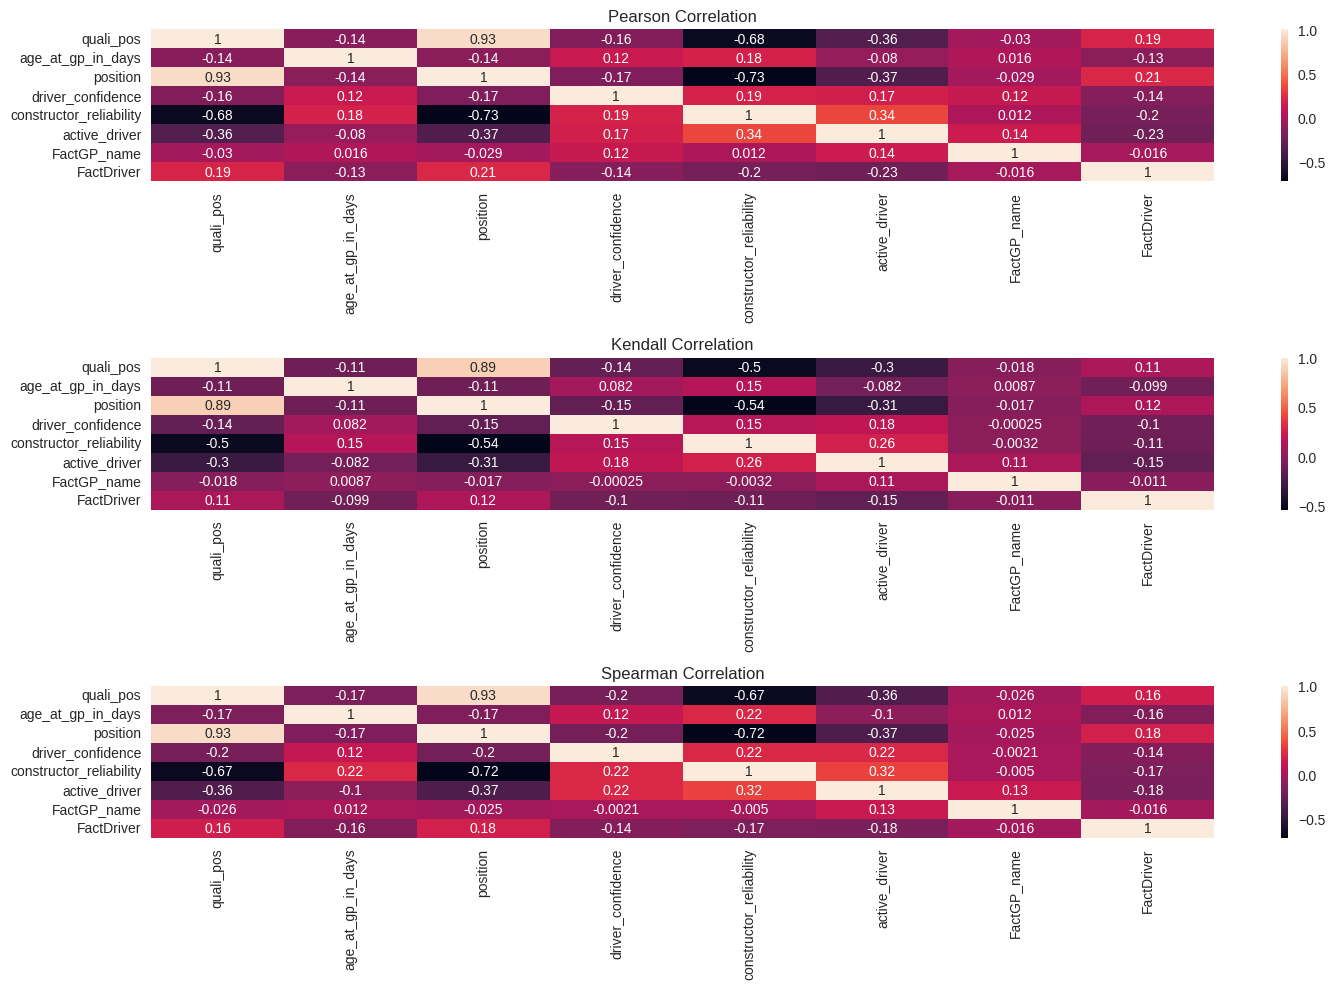

In [ ]:
showCorrelation(new_data_important, nCols=1)

## Do a correlation study of all variables in the dataset

In [ ]:
# data["label"] = pd.factorize(data["driver_nationality"])[0]
data['DateFactorized'] = pd.factorize(data['date'])[0]
data["DateFactorized"].head

<bound method NDFrame.head of 0         0
1         1
2         2
3         3
4         4
       ... 
5578    263
5579    263
5580    263
5581    263
5582    263
Name: DateFactorized, Length: 5583, dtype: int64>

In [ ]:
data.dtypes

year                                int64
date                       datetime64[ns]
fp1_date                           object
fp1_time                           object
fp2_date                           object
fp2_time                           object
fp3_date                           object
fp3_time                           object
quali_date                         object
quali_time                         object
sprint_date                        object
sprint_time                        object
quali_pos                           int64
statusId                            int64
position                            int64
dob                                object
driver_nationality                 object
constructor                        object
constructor_nationality            object
GP_name                            object
country                            object
driver                             object
age_at_gp_in_days                   int64
driver_home                       

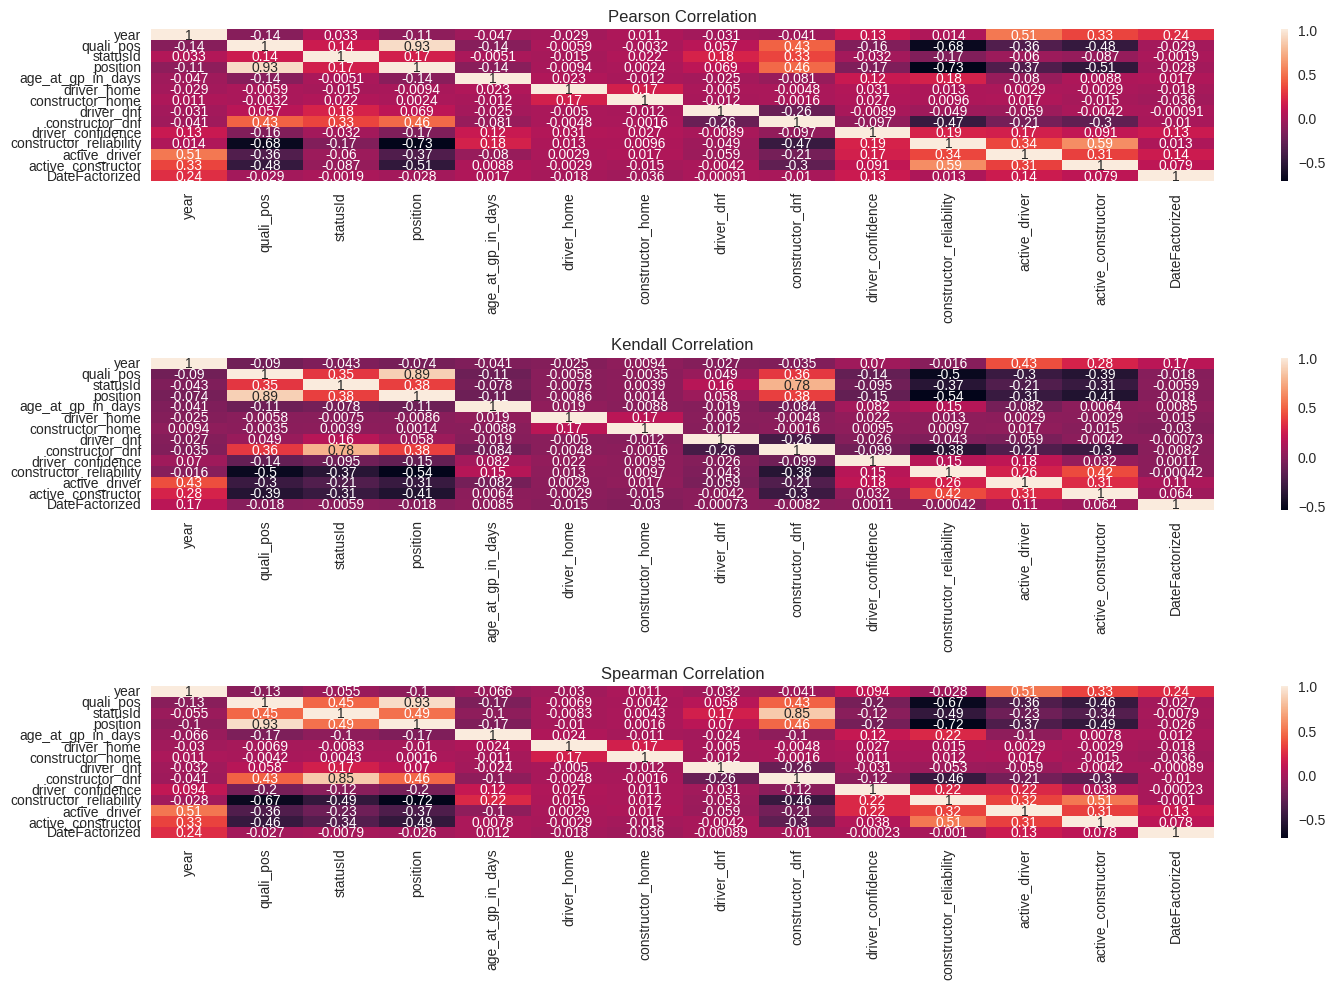

In [ ]:
showCorrelation(data, nCols=1)